In [337]:
import numpy as np
import random
from dataclasses import dataclass
from tqdm.auto import tqdm
from typing import List

In [338]:
problem = np.load('../data/problem_2.npz')
x = problem['x']
y = problem['y']

print(x.shape)
print(y.shape)
PROBLEM_SIZE = x.shape[0]

POPULATION_SIZE = PROBLEM_SIZE*20
OFFSPRING_SIZE = int(POPULATION_SIZE*0.5)
MAX_GENERATIONS = 200
INCREASE_COMPLEXITY_STEP = 20

(3, 5000)
(5000,)


In [339]:
rng = np.random.Generator(np.random.PCG64([POPULATION_SIZE, OFFSPRING_SIZE, MAX_GENERATIONS]))

In [340]:
# Operators

BINARY_OPERATORS = ["+", "-", "*", "/"]
UNARY_OPERATORS = ["sin", "cos","tan", "exp", "log","arcsin","arccos","arctan","sqrt","abs"]
VARIABLES = ["X_"+str(i) for i in range(PROBLEM_SIZE)]

VARIABLES_WEIGHTS = [[1/len(VARIABLES) for _ in range(len(VARIABLES))]]
VARIABLES_MAP = {var: i for i,var in enumerate(VARIABLES)}

In [341]:
@dataclass
class Individual:
    genome: list
    fitness: tuple

In [342]:
def compute_MSE(Y_pred, Y_real):
    
    MSE = 100*np.square(Y_real-Y_pred).sum()/len(Y_real)
    return MSE

In [343]:
def compute_unary_weights(unary_operators,j):
    """
    Compute unary operators weights depending on functions dominion and relation between input and output
    """
    W = {op: 0 for op in unary_operators}

    # Funzioni di dominio
    def is_valid_tan(x,curr):
        return np.abs(np.cos(x)) > 1e-9 and curr != -1

    def is_valid_log(x,curr):
        return x > 0 and curr != -1

    def is_valid_sqrt(x,curr):
        return x >= 0 and curr != -1

    def is_valid_arcsin_arccos(x,curr):
        return -1 <= x <= 1 and curr != -1

    
    for i in range(x.shape[1]):  # Per ogni riga di x
        curr_x = x[j, i]
        curr_y = y[i]

        for op in unary_operators:
            if op == "sin" or op == "cos":
                if np.abs(curr_y) > 100:
                    W[op] += 2
                elif -1 <= curr_y <= 1:
                    W[op] += 5  
                else:
                    W[op] += 2

            elif op == "tan":
                if is_valid_tan(curr_x, W[op]):
                    if np.abs(curr_y) > 100:
                        W[op] += 5  
                    else:
                        W[op] += 3
                else:
                    W[op] = -1

            elif op == "exp":
                if curr_y < 0 and curr_x<0:
                    W[op] +=1 
                elif np.abs(curr_y) > 100 * np.abs(curr_x):
                    W[op] += 5  
                else:
                    W[op] += 2

            elif op == "log":
                if is_valid_log(curr_x, W[op]):
                    if curr_x < 1 and curr_y < 0:
                        W[op] += 5  
                    elif curr_y < curr_x:
                        W[op] += 3  
                    else:
                        W[op] += 1
                else:
                    W[op] = -1

            elif op == "arcsin" or op == "arccos":
                if is_valid_arcsin_arccos(curr_x, W[op]):
                    if -np.pi/2 <= curr_y <= np.pi/2:
                        W[op] += 5 
                    else:
                        W[op] += 1
                else:
                    W[op] = -1

            elif op == "arctan":
                if -np.pi/2 <= curr_y <= np.pi/2:
                    W[op] += 5  
                else:
                    W[op] += 2

            elif op == "sqrt":
                if is_valid_sqrt(curr_x, W[op]):
                    if curr_y <= curr_x:
                        W[op] += 5  # lower input
                    else:
                        W[op] += 1
                else:
                    W[op] = -1
            elif op == "abs":
                if curr_y >0 and curr_x <0: 
                    W[op] += 3
                else:
                    W[op] += 2

    # Normalize weights
    WArray = [W[op] if W[op] != -1 else 0 for op in unary_operators]
    
    tot_sum = np.sum(WArray)
    if tot_sum > 0: 
        WArray = [float(w / tot_sum) for w in WArray]

    return WArray


In [344]:
UNARY_OPERATORS_WEIGHTS = [compute_unary_weights(UNARY_OPERATORS,i) for i in range(PROBLEM_SIZE)]
UNARY_OPERATORS_MAP = {op: i for i,op in enumerate(UNARY_OPERATORS)}
BINARY_OPERATORS_WEIGHTS = [[1/len(BINARY_OPERATORS) for _ in BINARY_OPERATORS] for _ in range(PROBLEM_SIZE)]
BINARY_OPERATORS_MAP = {op: i for i,op in enumerate(BINARY_OPERATORS)}

### Genetic Program Logic

We have to find a combination of X (numpy array for data of size (n,m)) with numpy operands that gives as result Y (numpy array for labels of size (m,)). <br>
Each formula (genome) will have the form: 
<br><br>
_0 Opb,1 A * Opu,1(X1*Av) Opb,2 B * Opu,2(X2*Bv) ... Opb,i I * Opu,i(Xi*Iv) ...Opb,n N * Opu,n(Xn*Nv)_

- n: Problem size
- Xi: Variable of col i for each row data sample
- A, B, ..I, ..N: costants positive or negative that works as weights for the single term
- Av, Bv, ..Iv, ..Nv: positive constants that wights only the single variable 
- Opu,n(..): unary operators for one variable
- Opb,n: binary operators between two terms

If the fitness doesn't improve for a fixed number of generation a generic term is added, increasing the complexity to _(prev_n + 1)_ 

Example of formula expression for 2 variable problem:
["1", "", "1", "X_0", "+", "0.2", "sin","1", "X_1", "+"]

In [345]:
UNARY_OPERATIONS = {
        "": lambda x: x,
        "sin": np.sin,
        "cos": np.cos,
        "tan":np.tan,
        "log": np.log,
        "exp": np.exp,
        "arccos": np.arccos,
        "arcsin":np.arcsin,
        "arctan":np.arctan,
        "sqrt":np.sqrt,
        "abs":np.abs
    }

In [346]:
def compute_FX_prev(F,X)->np.ndarray:
    
    def solve_row(row):
        Y_i = 0

        def solve_term(i,col,Y_i):
            unary_op_res = 0
            var_cost = float(F[2+5*i])
            if F[1+5*i]== "":
                unary_op_res = X[col,row]
            else: 
                unary_op_res= getattr(np, F[1+5*i])(X[col,row] * var_cost)

            T_i = float(F[5*i]) * unary_op_res
            Y_i = eval(f"Y_i {F[4+5*i]} T_i") if T_i !=0 else Y_i
            return Y_i
        
        for i in range(len(F)//5):
            col = int(F[3+5*i].split("_")[1])
            Y_i = solve_term(i,col, Y_i)
        return Y_i
    
    Y_pred = [solve_row(i) for i in range(x.shape[1])]
    
    mse = compute_MSE(Y_pred,y)
    increase = np.mean(np.abs(Y_pred)-np.abs(y)) < 0
    inc_dec_factor = np.mean(np.abs(Y_pred)-np.abs(y))
    right_sign = np.all((np.array(Y_pred)>0)==(y>0))
    count_right_sign = np.sum((np.array(Y_pred)>0)==(y>0))
    #if right_sign: print("\t\tRight sign combination found")
    return mse, increase, right_sign, count_right_sign, inc_dec_factor

In [347]:
def compute_FX(F, X):
    # Number of terms
    num_terms = len(F) // 5
    
    # Pre-compute fixed F values
    coefficients = np.array([float(F[5 * i]) for i in range(num_terms)])
    variable_costs = np.array([float(F[2 + 5 * i]) for i in range(num_terms)])
    columns = np.array([int(F[3 + 5 * i].split("_")[1]) for i in range(num_terms)])
    operations = [F[1 + 5 * i] for i in range(num_terms)]
    operators = [F[4 + 5 * i] for i in range(num_terms)]
    
    # MAp unary operations
    unary_funcs = [UNARY_OPERATIONS[op] for op in operations]
    # Computes for each row the result
    def solve_row(row):
        Y_i = 0.0
        for i in range(num_terms):
            unary_result = unary_funcs[i](X[columns[i], row] * variable_costs[i])
            T_i = coefficients[i] * unary_result
            if operators[i] == "+":
                Y_i += T_i
            elif operators[i] == "-":
                Y_i -= T_i
            elif operators[i] == "*":
                Y_i *= T_i
            elif operators[i] == "/":
                Y_i /= T_i if T_i != 0 else 1  # Per evitare divisioni per zero
        return Y_i
    
    Y_pred = np.array([solve_row(row) for row in range(X.shape[1])])
    
    # metrics
    mse = compute_MSE(Y_pred, y)
    diff_abs = np.abs(Y_pred) - np.abs(y)
    increase = np.mean(diff_abs) < 0
    inc_dec_factor = np.mean(diff_abs)
    right_sign = np.all((Y_pred > 0) == (y > 0))
    count_right_sign = np.sum((Y_pred > 0) == (y > 0))
    
    return mse, increase, right_sign, count_right_sign, inc_dec_factor


In [348]:
def new_term(individual_gen:List,n):
        # i = 0
    costant = rng.integers(0,np.min(np.abs(y))+1) # all terms are multiplied by a random number
    costant+=1 if costant == 0 else 0
    if np.any(y<0) and rng.random()<0.5: costant*=-1
    individual_gen.append(costant)

    # i = 3
    var = rng.choice(VARIABLES,1 ,p=VARIABLES_WEIGHTS[0]) [0] 
    VARIABLES_WEIGHTS[0][VARIABLES_MAP[var]] = 0.1
    VARIABLES_WEIGHTS[0] /= np.sum(VARIABLES_WEIGHTS[0])

    # i = 1
    unary_op = "" if rng.random() < 0.2 else str(rng.choice(UNARY_OPERATORS,1,p=UNARY_OPERATORS_WEIGHTS[int(var.split("_")[1])])[0])
    individual_gen.append(unary_op)

    # i = 2
    var_costant = 1 # the costant that multiply the variable start from 1
    individual_gen.append(var_costant)
    
    individual_gen.append(var)

    # i = 4
    bin_op = rng.choice(BINARY_OPERATORS,1) if n !=0 else rng.choice(["+","-"],1)
    individual_gen.append(str(bin_op[0]))

    return individual_gen

In [349]:
def generate_individual(max_depth=PROBLEM_SIZE)->Individual:
    individual_gen = []
    for n in range(max_depth):

        individual_gen = new_term(individual_gen,n)

    mse, _, right_sign, count, _ = compute_FX(individual_gen,x)    
    return Individual(individual_gen,(right_sign,-mse,count))

In [350]:
def add_term(population,terms_added):
    new_population = []
    for ind in population:
        new_genome = new_term(ind.genome.copy(),PROBLEM_SIZE+terms_added)
        mse, _, right_sign, count, _  = compute_FX(ind.genome,x) 
        new_fitness = (right_sign,-mse,count) 
        new_population.append(Individual(new_genome,new_fitness))
    return new_population

In [351]:
def parent_selection(population):
    # best by mse
    best_by_mse = population[:10]
    parent_1_candidates = rng.choice(best_by_mse, 5, replace=False)

    # best by right-sign count
    best_by_right_sign = sorted(population, key=lambda i: i.fitness[2], reverse=True)[:10]
    parent_2_candidates = rng.choice(best_by_right_sign, 5, replace=False)

    # combine two arrays
    combined_parents = np.concatenate((parent_1_candidates, parent_2_candidates))
    selected_parents = rng.choice(combined_parents, 2, replace=False)

    return selected_parents

In [352]:
def update_weights(genome, sync_factor, increase: bool):
    
    for i in range(len(genome) // 5):
        unary_term = genome[1 + 5 * i]
        binary_term = genome[4 + 5 * i]
        n_var = int(genome[3 + 5 * i].split("_")[1])  # Numero della variabile

        # Aggiorna i pesi per gli operatori unari
        if unary_term != "":
            unary_idx = UNARY_OPERATORS_MAP[unary_term]
            if increase:
                UNARY_OPERATORS_WEIGHTS[n_var][unary_idx] += sync_factor if UNARY_OPERATORS_WEIGHTS[n_var][unary_idx] <= 0.65 else 0
            else:
                UNARY_OPERATORS_WEIGHTS[n_var][unary_idx] -= sync_factor if UNARY_OPERATORS_WEIGHTS[n_var][unary_idx] >= 0.15 else 0
            # Normalizza i pesi
            UNARY_OPERATORS_WEIGHTS[n_var] /= np.sum(UNARY_OPERATORS_WEIGHTS[n_var])

        # Aggiorna i pesi per gli operatori binari
        binary_idx = BINARY_OPERATORS_MAP[binary_term]
        if increase:
            BINARY_OPERATORS_WEIGHTS[n_var][binary_idx] += sync_factor if BINARY_OPERATORS_WEIGHTS[n_var][binary_idx] <= 0.65 else 0
        else:
            BINARY_OPERATORS_WEIGHTS[n_var][binary_idx] -= sync_factor if BINARY_OPERATORS_WEIGHTS[n_var][binary_idx] >= 0.15 else 0
        # Normalizza i pesi
        BINARY_OPERATORS_WEIGHTS[n_var] /= np.sum(BINARY_OPERATORS_WEIGHTS[n_var])


In [353]:
def xover(p1: Individual, p2: Individual, terms_added) -> Individual:
    ''' Exchange terms between two individuals '''
    # Divide genomes into blocks
    blocks1 = [p1.genome[i:i + 5] for i in range(0, len(p1.genome), 5)]
    blocks2 = [p2.genome[i:i + 5] for i in range(0, len(p2.genome), 5)]
    if len(blocks1) != len(blocks2): print("error")
    child_genome = p1.genome.copy()
    new_fitness = ()
    right_sign = p1.fitness[0] or p2.fitness[0]

    rep_factor = 0
    while rep_factor<0.5:
        sync_factor = 0.05 if right_sign else 0.01
        # Select random blocks to exchange
        xover_blocks = rng.choice(range(len(blocks1)), rng.integers(0.5, len(blocks1)), replace=False)

        # Exchange blocks
        for b_i in xover_blocks:
            blocks1[b_i] = blocks2[b_i]

        # Rebuild child genome
        child_genome = [elem for block in blocks1 for elem in block]

        # Evaluate fitness
        new_mse, _, right_sign, count, _ = compute_FX(child_genome, x)
        new_fitness = (right_sign, -new_mse, count)

        # Update weights based on fitness
        if new_fitness > p1.fitness or new_fitness > p2.fitness:
            update_weights(child_genome, sync_factor, increase=True)
            break
        else:
            update_weights(child_genome, sync_factor, increase=False)
        
        rep_factor = rng.random()

    return Individual(child_genome, new_fitness)


In [354]:
def adjust_mutation_factor(mutation_factor, increase):
    if increase: 
            mutation_factor= mutation_factor* 1.2 if mutation_factor >=1 else 1.2
            if mutation_factor>1e2: mutation_factor*=0.5
    else: 
        mutation_factor= mutation_factor* 0.8 if mutation_factor <=1 else 0.8
    return mutation_factor

In [355]:
def mutation(p: Individual, mutation_factor: float, terms_added) :
    ''' Mutate terms of one individual '''
    child_genome = p.genome.copy()
    new_fitness = ()
    blocks = [child_genome[i:i + 5] for i in range(0, len(child_genome), 5)]
    right_sign = p.fitness[0]
    rep_factor=0
    
    while rep_factor<0.6:
        sync_factor = 0.05 if right_sign else 0.01
        # Define mutation probabilities
        mutation_probs = np.array([0.15, 0.35, 0.2, 0, 0.3]) if right_sign else np.array([0.4, 0.1, 0.4, 0, 0.1])

        # Select random blocks to mutate
        if len(blocks) == 1:
            mutate_blocks = [0]
        else:
            mutate_blocks = rng.choice(range(len(blocks)), rng.integers(1, len(blocks)), replace=False)

        for b_i in mutate_blocks:
            # Mutate elements in the block
            elems = rng.choice(5, size=rng.integers(1, 5), p=mutation_probs)
            n_var = int(blocks[b_i][3].split("_")[1])

            for e_i in elems:
                if e_i == 0:
                    blocks[b_i][e_i] *= mutation_factor if blocks[b_i][e_i] < 1e4 else rng.random()
                    if not right_sign: blocks[b_i][e_i]*=-1
                elif e_i == 1:
                    new_unary_op = "" if rng.random() < 0.2 else str(rng.choice(UNARY_OPERATORS,1,p=UNARY_OPERATORS_WEIGHTS[n_var])[0])
                    blocks[b_i][e_i] = new_unary_op
                    if new_unary_op in ["arccos","arcsin","arctan","log","sqrt"] and (blocks[b_i][2] >= 1 or blocks[b_i][2] <= 0) or new_unary_op == "": 
                        blocks[b_i][2] = 1
                 
                elif e_i == 2 and blocks[b_i][1] not in ["arccos","arcsin","arctan"]:
                    blocks[b_i][e_i] *= mutation_factor if blocks[b_i][e_i] < 1e2 else rng.random()
                    if blocks[b_i][1] not in ["log","sqrt"] and not right_sign:
                        blocks[b_i][e_i]*=-1 
                elif e_i == 4:
                    new_bin_op = rng.choice(BINARY_OPERATORS,1,p=BINARY_OPERATORS_WEIGHTS[n_var]) if b_i !=0 else rng.choice(["+","-"],1)
                    blocks[b_i][e_i] = str(new_bin_op[0])  
                else:
                    continue

        # Rebuild genome and compute fitness
        child_genome = [elem for block in blocks for elem in block]
        new_mse, increase, right_sign, count, inc_factor = compute_FX(child_genome, x)
        new_fitness = (right_sign, -new_mse, count)

        if new_fitness > p.fitness:
            update_weights(child_genome, sync_factor, increase=True)
            break
        else:
            update_weights(child_genome, sync_factor, increase=False)

        # Adjust mutation factor
        mutation_factor = adjust_mutation_factor(mutation_factor, increase)

        rep_factor = rng.random()

    return Individual(child_genome, new_fitness), mutation_factor


In [356]:
def EA_resolution(population):
    history = []
    mutation_factor = 1
    n_no_improvement = 0
    terms_added = 0
    champion = population[0]
    for i in tqdm(range(MAX_GENERATIONS)):

        offspring = list()

        for _ in range(OFFSPRING_SIZE):
            
            p1,p2 = parent_selection(population)
            
            if rng.random() <0.5 and not champion.fitness[0]:
                o = xover(p1,p2,terms_added)
            else:
                o,mutation_factor = mutation(p1,mutation_factor,terms_added)

            offspring.append(o)

        population.extend(offspring)

        best_mse = sorted(population, key=lambda i: i.fitness,reverse=True)
        best_count = sorted(population, key=lambda i: i.fitness[2],reverse=True)

        population = best_mse[:POPULATION_SIZE//2] + best_count[:POPULATION_SIZE//2]

        if population[0].fitness > champion.fitness:
            champion = population[0]
            n_no_improvement = 0
        else:
            n_no_improvement += 1
        
        if n_no_improvement > INCREASE_COMPLEXITY_STEP :
            if terms_added == 3:
                print("\t\tEarly stopping: Problem complexity too high")
                break
            print("\t\tChanging population")
            population = add_term(population,terms_added)
            population.sort(key=lambda i: i.fitness,reverse=True)
            terms_added +=1
            n_no_improvement = 0
            print(f"\t\tNew problem complexity: {PROBLEM_SIZE+terms_added}")
        elif n_no_improvement == INCREASE_COMPLEXITY_STEP-10:
            # to prevent overfitting, before increasing problem complexity try to reset weights
            print("\t\tReset weights")
            for i in range(PROBLEM_SIZE):
                UNARY_OPERATORS_WEIGHTS[i] = compute_unary_weights(UNARY_OPERATORS,i) 
                BINARY_OPERATORS_WEIGHTS[i] = [1/len(BINARY_OPERATORS) for _ in BINARY_OPERATORS]
            
        history.append(population[0])

        if i % 10 == 0 and i!= 0:
            print(f"\t\tBest individual found at iteration {i}:")
            print(f"\t\t\t{champion.genome}")
            print(f"\t\t\t{champion.fitness}")
        
        if -champion.fitness[1]<1e-30:
            print(f"\t\t\tEarly stopping: Near Solution Found")
            break

    return champion, history

In [357]:
POPULATION = [generate_individual() for _ in range(POPULATION_SIZE)]
print(POPULATION)
winner, history = EA_resolution(POPULATION)
print("\t\tChampion")
print(winner)

[Individual(genome=[np.int64(114), 'tan', 1, np.str_('X_2'), '-', np.int64(51), '', 1, np.str_('X_0'), '/', np.int64(23), '', 1, np.str_('X_2'), '+'], fitness=(np.False_, np.float64(-2961690854791888.0), np.int64(2734))), Individual(genome=[np.int64(5), 'tan', 1, np.str_('X_1'), '-', np.int64(39), 'abs', 1, np.str_('X_0'), '+', np.int64(92), 'exp', 1, np.str_('X_2'), '-'], fitness=(np.False_, np.float64(-2962023455532647.0), np.int64(2290))), Individual(genome=[np.int64(52), 'abs', 1, np.str_('X_1'), '+', np.int64(20), '', 1, np.str_('X_1'), '/', np.int64(-98), 'exp', 1, np.str_('X_2'), '+'], fitness=(np.False_, np.float64(-2962043044170461.0), np.int64(2429))), Individual(genome=[np.int64(-2), '', 1, np.str_('X_0'), '-', np.int64(-62), '', 1, np.str_('X_2'), '+', np.int64(-10), 'cos', 1, np.str_('X_1'), '/'], fitness=(np.False_, np.float64(-2961709854578086.5), np.int64(2553))), Individual(genome=[np.int64(-13), 'tan', 1, np.str_('X_2'), '+', np.int64(-10), 'abs', 1, np.str_('X_0'), '

  2%|▏         | 3/200 [00:03<03:57,  1.21s/it]C:\Users\loren\AppData\Local\Temp\ipykernel_5320\823605592.py:3: RuntimeWarning: overflow encountered in square
  MSE = 100*np.square(Y_real-Y_pred).sum()/len(Y_real)
  6%|▌         | 11/200 [00:13<03:33,  1.13s/it]

		Best individual found at iteration 10:
			[np.int64(88), '', 1, np.str_('X_0'), '+', np.int64(63), 'abs', 55.20614389124362, np.str_('X_2'), '*', np.int64(-48), 'arctan', 1, np.str_('X_2'), '-']
			(np.False_, np.float64(-2387642686185868.0), np.int64(3869))


 10%|█         | 21/200 [00:25<03:22,  1.13s/it]

		Best individual found at iteration 20:
			[np.float64(-152.064), 'arctan', 1, np.str_('X_0'), '+', np.float64(-108.864), 'abs', 55.20614389124362, np.str_('X_2'), '*', np.float64(-206.39121408), 'arctan', 1, np.str_('X_2'), '-']
			(np.False_, np.float64(-2325801240431627.5), np.int64(3869))


 16%|█▌        | 31/200 [00:39<03:52,  1.38s/it]

		Best individual found at iteration 30:
			[np.float64(-152.064), 'arctan', 1, np.str_('X_0'), '+', np.float64(-108.864), 'abs', 55.20614389124362, np.str_('X_2'), '*', np.float64(-19688.9409718081), 'exp', 1, np.str_('X_2'), '-']
			(np.False_, np.float64(-2293630943153231.5), np.int64(3880))


 17%|█▋        | 34/200 [00:43<04:07,  1.49s/it]C:\Users\loren\AppData\Local\Temp\ipykernel_5320\3950132214.py:18: RuntimeWarning: overflow encountered in exp
  unary_result = unary_funcs[i](X[columns[i], row] * variable_costs[i])
C:\Users\loren\AppData\Local\Temp\ipykernel_5320\3950132214.py:27: RuntimeWarning: overflow encountered in scalar divide
  Y_i /= T_i if T_i != 0 else 1  # Per evitare divisioni per zero
C:\Users\loren\AppData\Local\Temp\ipykernel_5320\3950132214.py:19: RuntimeWarning: overflow encountered in scalar multiply
  T_i = coefficients[i] * unary_result
 20%|██        | 41/200 [00:52<03:08,  1.19s/it]

		Best individual found at iteration 40:
			[np.float64(5829.768794915326), '', 196.7385795703244, np.str_('X_0'), '+', np.float64(316.6998879220531), 'sin', -8.559456430325758, np.str_('X_0'), '+', np.float64(-1022.3359979859932), 'abs', 0.6400000000000001, np.str_('X_2'), '-']
			(np.False_, np.float64(-1902150968189633.8), np.int64(3869))


C:\Users\loren\AppData\Local\Temp\ipykernel_5320\3950132214.py:25: RuntimeWarning: overflow encountered in scalar multiply
  Y_i *= T_i
 26%|██▌       | 51/200 [01:04<02:44,  1.10s/it]

		Best individual found at iteration 50:
			[np.float64(5829.768794915326), '', 196.7385795703244, np.str_('X_0'), '+', np.float64(39835.14196593284), 'cos', -79.49684720339083, np.str_('X_0'), '+', np.float64(-1022.3359979859932), 'abs', 29.4432767419966, np.str_('X_2'), '-']
			(np.False_, np.float64(-1900585443437437.2), np.int64(3866))


 30%|███       | 61/200 [01:15<02:49,  1.22s/it]

		Best individual found at iteration 60:
			[np.float64(5829.768794915326), '', 196.7385795703244, np.str_('X_0'), '+', np.float64(28649.61638051251), 'cos', -129.92162877900932, np.str_('X_0'), '+', np.float64(-7596.042041592632), '', 1, np.str_('X_2'), '-']
			(np.False_, np.float64(-1898330230443154.2), np.int64(3872))


C:\Users\loren\AppData\Local\Temp\ipykernel_5320\823605592.py:3: RuntimeWarning: overflow encountered in scalar multiply
  MSE = 100*np.square(Y_real-Y_pred).sum()/len(Y_real)
 36%|███▌      | 71/200 [01:27<02:31,  1.17s/it]

		Best individual found at iteration 70:
			[np.float64(5829.768794915326), '', 196.7385795703244, np.str_('X_0'), '+', np.float64(-4339.10817992515), 'cos', -97.65136919944695, np.str_('X_0'), '+', np.float64(39193.908479175625), '', -7.430083706879999, np.str_('X_2'), '-']
			(np.False_, np.float64(-1837545560965808.0), np.int64(4013))


 40%|████      | 81/200 [01:38<02:07,  1.07s/it]

		Best individual found at iteration 80:
			[np.float64(5829.768794915326), '', 196.7385795703244, np.str_('X_0'), '+', np.float64(28649.61638051251), 'cos', -129.92162877900932, np.str_('X_0'), '+', np.float64(39193.908479175625), '', -7.430083706879999, np.str_('X_2'), '-']
			(np.False_, np.float64(-1837192078074586.2), np.int64(4011))


 41%|████      | 82/200 [01:39<02:12,  1.12s/it]

		Reset weights


 46%|████▌     | 91/200 [01:50<02:03,  1.14s/it]

		Best individual found at iteration 90:
			[np.float64(5829.768794915326), '', 196.7385795703244, np.str_('X_0'), '+', np.float64(28649.61638051251), 'cos', -129.92162877900932, np.str_('X_0'), '+', np.float64(39193.908479175625), '', -7.430083706879999, np.str_('X_2'), '-']
			(np.False_, np.float64(-1837192078074586.2), np.int64(4011))


 46%|████▌     | 92/200 [01:51<01:54,  1.06s/it]

		Changing population


 46%|████▋     | 93/200 [01:53<02:37,  1.47s/it]

		New problem complexity: 4


 50%|█████     | 101/200 [02:07<02:58,  1.80s/it]

		Best individual found at iteration 100:
			[np.float64(5829.768794915326), '', 196.7385795703244, np.str_('X_0'), '+', np.float64(28649.61638051251), 'cos', -129.92162877900932, np.str_('X_0'), '+', np.float64(39193.908479175625), '', -7.430083706879999, np.str_('X_2'), '-', np.int64(-86), 'tan', 1, np.str_('X_2'), '-']
			(np.False_, np.float64(-1837086661931761.8), np.int64(4011))


 56%|█████▌    | 111/200 [02:23<02:17,  1.54s/it]

		Best individual found at iteration 110:
			[np.float64(5829.768794915326), '', 196.7385795703244, np.str_('X_0'), '+', np.float64(49683.01851058262), 'abs', 1, np.str_('X_0'), '+', np.float64(39193.908479175625), '', -7.430083706879999, np.str_('X_2'), '-', np.float64(-532.4893323264), 'tan', 6.191736422399999, np.str_('X_2'), '-']
			(np.False_, np.float64(-1835417276155017.8), np.int64(4008))


 60%|██████    | 121/200 [02:39<02:13,  1.68s/it]

		Best individual found at iteration 120:
			[np.float64(5829.768794915326), '', 195.87898151114305, np.str_('X_0'), '+', np.float64(49683.01851058262), 'abs', 1, np.str_('X_0'), '+', np.float64(39193.908479175625), '', -7.430083706879999, np.str_('X_2'), '-', np.float64(-532.4893323264), 'tan', 6.191736422399999, np.str_('X_2'), '-']
			(np.False_, np.float64(-1835298219560610.5), np.int64(4011))


 66%|██████▌   | 131/200 [02:55<01:49,  1.58s/it]

		Best individual found at iteration 130:
			[np.float64(5829.768794915326), '', 195.87898151114305, np.str_('X_0'), '+', np.float64(49683.01851058262), 'abs', 1, np.str_('X_0'), '+', np.float64(-30066.539335801233), '', 8.916100448255998, np.str_('X_2'), '-', np.float64(-532.4893323264), 'tan', 6.191736422399999, np.str_('X_2'), '-']
			(np.False_, np.float64(-1835275144858173.5), np.int64(4004))


 66%|██████▌   | 132/200 [02:56<01:46,  1.57s/it]

		Reset weights


 70%|███████   | 141/200 [03:11<01:37,  1.65s/it]

		Best individual found at iteration 140:
			[np.float64(5829.768794915326), '', 195.87898151114305, np.str_('X_0'), '+', np.float64(49683.01851058262), 'arctan', 1, np.str_('X_0'), '+', np.float64(-30066.539335801233), '', 8.916100448255998, np.str_('X_2'), '-', np.float64(-766.784638550016), 'tan', 8.916100448255998, np.str_('X_2'), '-']
			(np.False_, np.float64(-1833936408716736.2), np.int64(3999))


 76%|███████▌  | 151/200 [03:28<01:20,  1.64s/it]

		Reset weights


 80%|████████  | 161/200 [03:43<01:01,  1.57s/it]

		Best individual found at iteration 160:
			[np.float64(-12088.60857313642), '', -92.27071758561266, np.str_('X_0'), '+', np.float64(49683.01851058262), 'arctan', 1, np.str_('X_0'), '+', np.float64(-30066.539335801233), '', 8.916100448255998, np.str_('X_2'), '-', np.float64(-766.784638550016), 'tan', 8.916100448255998, np.str_('X_2'), '-']
			(np.False_, np.float64(-1833169732382554.5), np.int64(4004))


 84%|████████▎ | 167/200 [03:53<00:58,  1.79s/it]

		Reset weights


 86%|████████▌ | 171/200 [04:01<00:51,  1.78s/it]

		Best individual found at iteration 170:
			[np.float64(-12088.60857313642), '', -92.27071758561266, np.str_('X_0'), '+', np.float64(49683.01851058262), 'arctan', 1, np.str_('X_0'), '+', np.float64(-30066.539335801233), '', 8.916100448255998, np.str_('X_2'), '-', np.float64(-766.784638550016), 'tan', 8.916100448255998, np.str_('X_2'), '-']
			(np.False_, np.float64(-1833169732382554.5), np.int64(4004))


 88%|████████▊ | 177/200 [04:10<00:36,  1.60s/it]

		Changing population


 89%|████████▉ | 178/200 [04:13<00:43,  2.00s/it]

		New problem complexity: 5


 90%|█████████ | 181/200 [04:18<00:34,  1.83s/it]

		Best individual found at iteration 180:
			[np.float64(-12088.60857313642), '', -92.27071758561266, np.str_('X_0'), '+', np.float64(49683.01851058262), 'arctan', 1, np.str_('X_0'), '+', np.float64(-30066.539335801233), '', 8.916100448255998, np.str_('X_2'), '-', np.float64(-766.784638550016), 'tan', 8.916100448255998, np.str_('X_2'), '-', np.int64(-36), '', -237.3763137997697, np.str_('X_1'), '+']
			(np.False_, np.float64(-1828830135406478.8), np.int64(4005))


 96%|█████████▌| 191/200 [04:42<00:20,  2.28s/it]

		Best individual found at iteration 190:
			[np.float64(-12088.60857313642), '', -92.27071758561266, np.str_('X_0'), '+', np.float64(49683.01851058262), 'arctan', 1, np.str_('X_0'), '+', np.float64(-30066.539335801233), '', 8.916100448255998, np.str_('X_2'), '-', np.float64(-766.784638550016), 'tan', 8.916100448255998, np.str_('X_2'), '-', np.float64(51.839999999999996), '', 341.82189187166836, np.str_('X_1'), '+']
			(np.False_, np.float64(-1824306524291644.8), np.int64(4014))


 98%|█████████▊| 195/200 [04:51<00:11,  2.23s/it]

		Reset weights


100%|██████████| 200/200 [05:03<00:00,  1.52s/it]

		Champion
Individual(genome=[np.float64(-12088.60857313642), '', -92.27071758561266, np.str_('X_0'), '+', np.float64(49683.01851058262), 'arctan', 1, np.str_('X_0'), '+', np.float64(-30066.539335801233), '', 8.916100448255998, np.str_('X_2'), '-', np.float64(-766.784638550016), 'tan', 8.916100448255998, np.str_('X_2'), '-', np.float64(51.839999999999996), '', 341.82189187166836, np.str_('X_1'), '+'], fitness=(np.False_, np.float64(-1824306524291644.8), np.int64(4014)))


In [358]:
def compute_FX_test(F,X)->np.ndarray:
    
    def solve_row(row):
        Y_i = 0

        def solve_term(i,col,Y_i):
            unary_op_res = 0
            var_cost = float(F[2+5*i])
            if F[1+5*i]== "":
                unary_op_res = X[col,row] * var_cost
            else: 
                unary_op_res= getattr(np, F[1+5*i])(X[col,row] * var_cost)

            T_i = float(F[5*i]) * unary_op_res
            Y_i = eval(f"Y_i {F[4+5*i]} T_i") if T_i !=0 else Y_i
            return Y_i
        
        for i in range(len(F)//5):
            col = int(F[3+5*i].split("_")[1])
            Y_i = solve_term(i,col, Y_i)
        return Y_i
    
    Y_pred = [solve_row(i) for i in range(x.shape[1])]
    mse = compute_MSE(Y_pred,y)
    increase = np.mean(np.abs(Y_pred)-np.abs(y)) < 0
    
    right_sign = np.all((np.array(Y_pred)>0)==(y>0))
    #if right_sign: print(right_sign)
    return mse, increase, right_sign, Y_pred

In [359]:
mse, inc, signs, Y_pred = compute_FX_test(winner.genome,x)

print(np.sum((np.array(Y_pred)>0)==(y>0)))
print(mse)

mse, increase, right_sign, count_right_sign, inc_dec_factor = compute_FX(winner.genome,x)

print(mse)

4014
1824306524291644.8
1824306524291644.8


In [360]:
for i in range(len(y)//2):
    print(f"Pred: {Y_pred[i]}, Real: {y[i]}") 

Pred: 4693258.483262214, Real: 7410414.436905311
Pred: 3112963.777955798, Real: 2718394.7537429086
Pred: -5723319.19266162, Real: -2965018.4469077196
Pred: 3092620.1634119665, Real: 4842657.318560673
Pred: 6669135.553178877, Real: 2800313.072205193
Pred: 117941.03603464013, Real: -304885.65580567275
Pred: -818682.1675393524, Real: 4510537.606158223
Pred: -2157078.3494276977, Real: -3704800.7764973883
Pred: 277599.55471907946, Real: 3392830.1850896296
Pred: 513665.2322162636, Real: -5076835.591756221
Pred: -2147363.1391599346, Real: -7083365.82023165
Pred: 4481723.289878162, Real: 1856732.5824224877
Pred: -613997.1095340059, Real: -6391392.114313396
Pred: -3591259.3264036644, Real: -5576396.247023077
Pred: -3537414.456710416, Real: -1730138.6092167827
Pred: -5856973.443204023, Real: 4915935.939596139
Pred: 579974.213423671, Real: -3545576.5321127996
Pred: -1061334.8118150907, Real: -7159671.777624452
Pred: -4180180.0742625934, Real: -7014391.192538479
Pred: -2406015.3133753757, Real: 20

In [361]:
UNARY_OPERATORS_WEIGHTS

[array([0.15031917, 0.17429107, 0.23449693, 0.14911971, 0.        ,
        0.        , 0.        , 0.14229971, 0.        , 0.14947341]),
 array([0.14893526, 0.14893526, 0.24384145, 0.14375166, 0.        ,
        0.        , 0.        , 0.14893526, 0.        , 0.16560111]),
 array([0.14694806, 0.20027476, 0.14835623, 0.17701036, 0.        ,
        0.        , 0.        , 0.14187712, 0.        , 0.18553348])]

In [362]:
BINARY_OPERATORS_WEIGHTS

[array([0.1421288 , 0.15292003, 0.14429312, 0.56065804]),
 array([0.14421005, 0.21776858, 0.31972382, 0.31829755]),
 array([0.2653799 , 0.14326699, 0.1812098 , 0.4101433 ])]

Text(0, 0.5, 'Count')

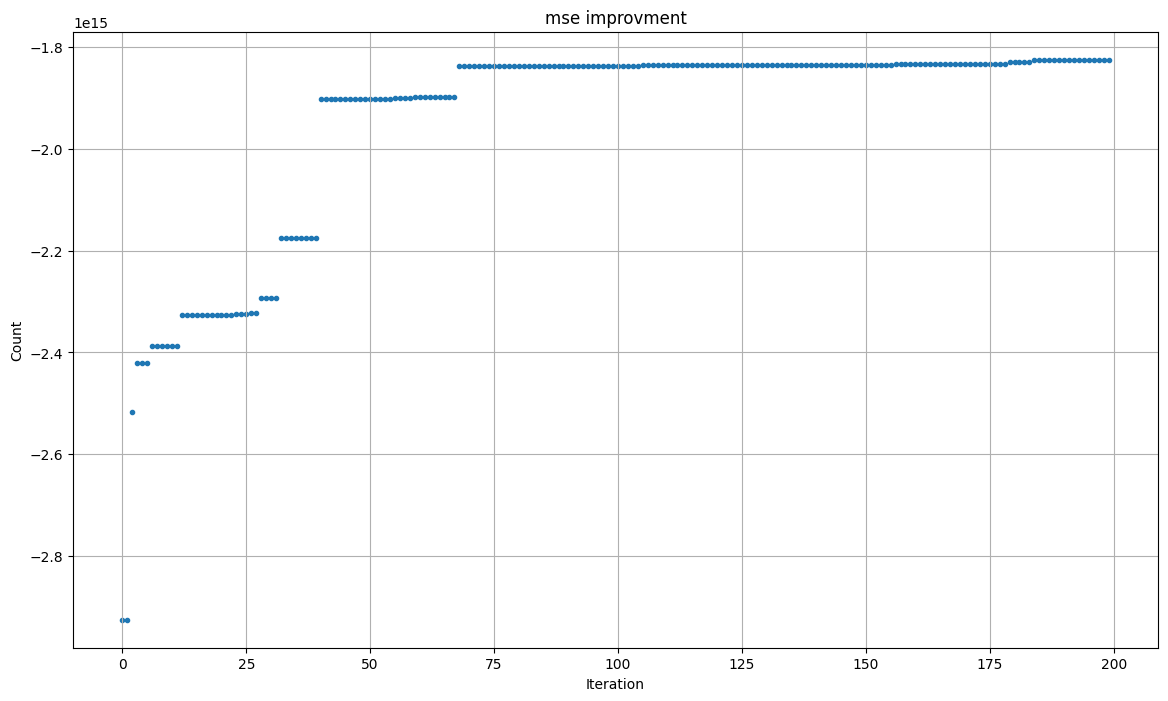

In [363]:
#from itertools import accumulate
from matplotlib import pyplot as plt

#valid = [sol.fitness for sol in list(accumulate(history, max))]
#Array of all costs only
costs = [sol.fitness[1] for sol in history]
#Plot
plt.figure(figsize=(14, 8))             
plt.title("mse improvment")
plt.grid()

plt.scatter(range(len(costs)), costs, marker=".")

plt.xlabel('Iteration')
plt.ylabel('Count')

In [364]:
print([x[:,i] for i in range(x.shape[1])])
print([y[i] for i in range(len(y))])

[array([ 4.52991777, -0.18656382, -1.60071107]), array([1.90003334, 4.07797331, 3.23380643]), array([-4.72053815, -0.08251329, -1.4492076 ]), array([1.84253283, 2.63938504, 3.49710299]), array([ 4.85794916, -3.27643345,  4.62640829]), array([-0.51604452, -1.93097705,  2.80346083]), array([-1.14074745,  3.16032052,  1.6461586 ]), array([-2.88939877, -0.48228432,  4.23686453]), array([-0.17078127,  0.43218069,  1.74922152]), array([ 1.50550646, -1.47559732, -4.44134698]), array([-2.83714256, -3.3100817 ,  4.24142405]), array([3.26600881, 2.31053698, 2.74226795]), array([-0.82682961, -3.83440496,  1.52651089]), array([-3.61387981, -4.22730615,  2.15967944]), array([-2.35759655, -4.03804073, -2.89974599]), array([-4.93418048, -4.74367827, -0.74897432]), array([ 0.83485972, -2.30764631, -1.29163084]), array([-1.21821096, -3.94565743,  1.52906758]), array([-4.09521142,  1.98865768,  1.5522432 ]), array([-2.62896541,  4.46349994,  1.88652608]), array([ 3.16016486, -1.94871325,  4.62759999]), 